# Cell-type deconvolution using Tangram

More details in:

https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html

https://github.com/broadinstitute/Tangram/blob/master/tangram_tutorial.ipynb


Test with one section, select Donor3_Wound7

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import os, sys

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

print(f"tangram=={tg.__version__}")

%load_ext autoreload
%autoreload 2
#%load_ext lab_black

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
squidpy==1.1.2
tangram==1.0.0


# Load data

### ST data

Load ST data, obs! Load from scratch and then subset for the spots that were filtered in Seurat

In [2]:
input_dir = "../../deconv/inputs/"
output_dir = "../../deconv/results/tangram/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


    
sample = "Donor3_Wound7"
outdir = os.path.join(output_dir,sample)
if not os.path.exists(outdir):
    os.makedirs(outdir)
indir = os.path.join(input_dir,"st_data",sample)   
    

fh = open(os.path.join(indir, "rawdata_path.csv"),"r+")
raw_path = fh.read()
fh.close()
print(raw_path)   
raw_path = raw_path.strip()
  



../../spatial/rawdata//Donor_3_4/P20063_107



In [3]:
adata_st = sc.read_visium(raw_path, library_id = sample)
adata_st.var_names_make_unique()
adata_st

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1749 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
# read in the barcodes
barcodes = pd.read_csv(os.path.join(indir, "barcodes.csv"), header = None)

# subset
adata_st = adata_st[adata_st.obs.index.isin(barcodes[0]),:]
adata_st

View of AnnData object with n_obs × n_vars = 1725 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

### Load SC data

In [5]:
sc_dir = '../../scRNAseq/results/'
sc_path = os.path.join(input_dir, "sc_data", "s1_subsampled.h5ad")
adata_sc = sc.read_h5ad(sc_path)
adata_sc

AnnData object with n_obs × n_vars = 9120 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'cl.annot'
    var: 'features'

In [6]:
# has normalized counts in .X and counts in raw.X
# OBS! The raw matrix has numericals instead of gene names as var.index
adata_sc.raw.var.index = adata_sc.var.index


In [7]:
# Revert back to raw matrix to have all genes
adata_sc = adata_sc.raw.to_adata()


In [8]:
adata_sc.obs['cl.annot'].value_counts()

VE             385
Mast-cell      381
Granular-II    380
Mono-Mac       378
FB-II          376
Th             376
Spinous-I      374
MEL            374
Granular-I     373
PC-vSMC        368
Basal-I        368
Mac            367
FB-IV          367
FB-III         367
Spinous-II     367
NK-cell        366
Basal-II       366
Spinous-III    364
FB-I           352
DC             312
B-cell         292
Basal-III      290
Basal-IV       286
LE             283
LC             237
Mono-DC        235
Schwann        136
Name: cl.annot, dtype: int64

### DEGs

In [9]:
deg_path = os.path.join(input_dir, "sc_data", "degs_fc0.5_pval0.01.txt")
genes = pd.read_csv(deg_path, header=None) 
genes

0
0         KRT1
1        KRT10
2       KRTDAP
3         DMKN
4      LGALS7B
...        ...
5116    R3HCC1
5117  RNASEH2C
5118   IGF2BP2
5119     GPR17
5120     PDS5B

[5121 rows x 1 columns]

In [10]:
# check that the genes are in the datasets

print(genes.isin(adata_st.var_names).sum())
print(genes.isin(adata_sc.var_names).sum())


genes = list(genes[0])


0    5121
dtype: int64
0    5121
dtype: int64


### Preprocess ST data

Run normalization and QC calculation

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


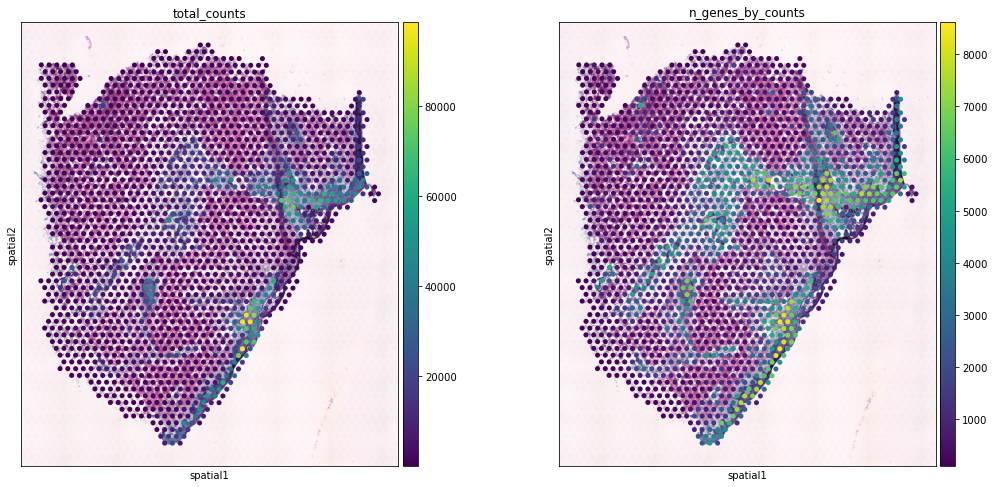

In [11]:
sc.pp.calculate_qc_metrics(adata_st, inplace=True)
adata_st.raw = adata_st
sc.pp.normalize_per_cell(adata_st)

plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata_st, img_key="hires", color=["total_counts", "n_genes_by_counts"], library_id = sample)



In [12]:
# same normalization for SC data
sc.pp.normalize_per_cell(adata_sc)



## Deconvolution and mapping
At this stage, we have all we need for the deconvolution task. 
First, we need to find a set of common genes the single cell and spatial datasets. 
We will use the top 100 DEGs per single cell cluster. Other common gene sets are variable genes in SC data, intersection of the highly variable genes from both datasets.

In [13]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:5114 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:21007 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Now we are ready to instantiate the model object and its hyper parameters. Note that we are loading `torch` and training the model on the GPU. However, it's also possible to train it on the CPU, it will just be slower.

In [14]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="cells",
    scale=False,
#    target_count=adata_st.obs.cell_count.sum(),
#    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    density_prior='rna_count_based',
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5114 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.203, KL reg: 0.000
Score: 0.344, KL reg: 0.000
Score: 0.349, KL reg: 0.000
Score: 0.350, KL reg: 0.000
Score: 0.351, KL reg: 0.000
Score: 0.351, KL reg: 0.000
Score: 0.351, KL reg: 0.000
Score: 0.352, KL reg: 0.000
Score: 0.352, KL reg: 0.000
Score: 0.352, KL reg: 0.000


INFO:root:Saving results..


In [15]:
ad_map

AnnData object with n_obs × n_vars = 9120 × 1725
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'cl.annot', 'n_counts'
    var: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [16]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cl.annot")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [17]:
adata_st.obsm["tangram_ct_pred"].to_csv(os.path.join(outdir,"tangram_fc0.5_pval0.01_cpm.csv"))

In [18]:
# add predictions to adata_st

adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)


In [19]:
celltypes = adata_sc.obs['cl.annot'].unique()
celltypes = sorted(celltypes)

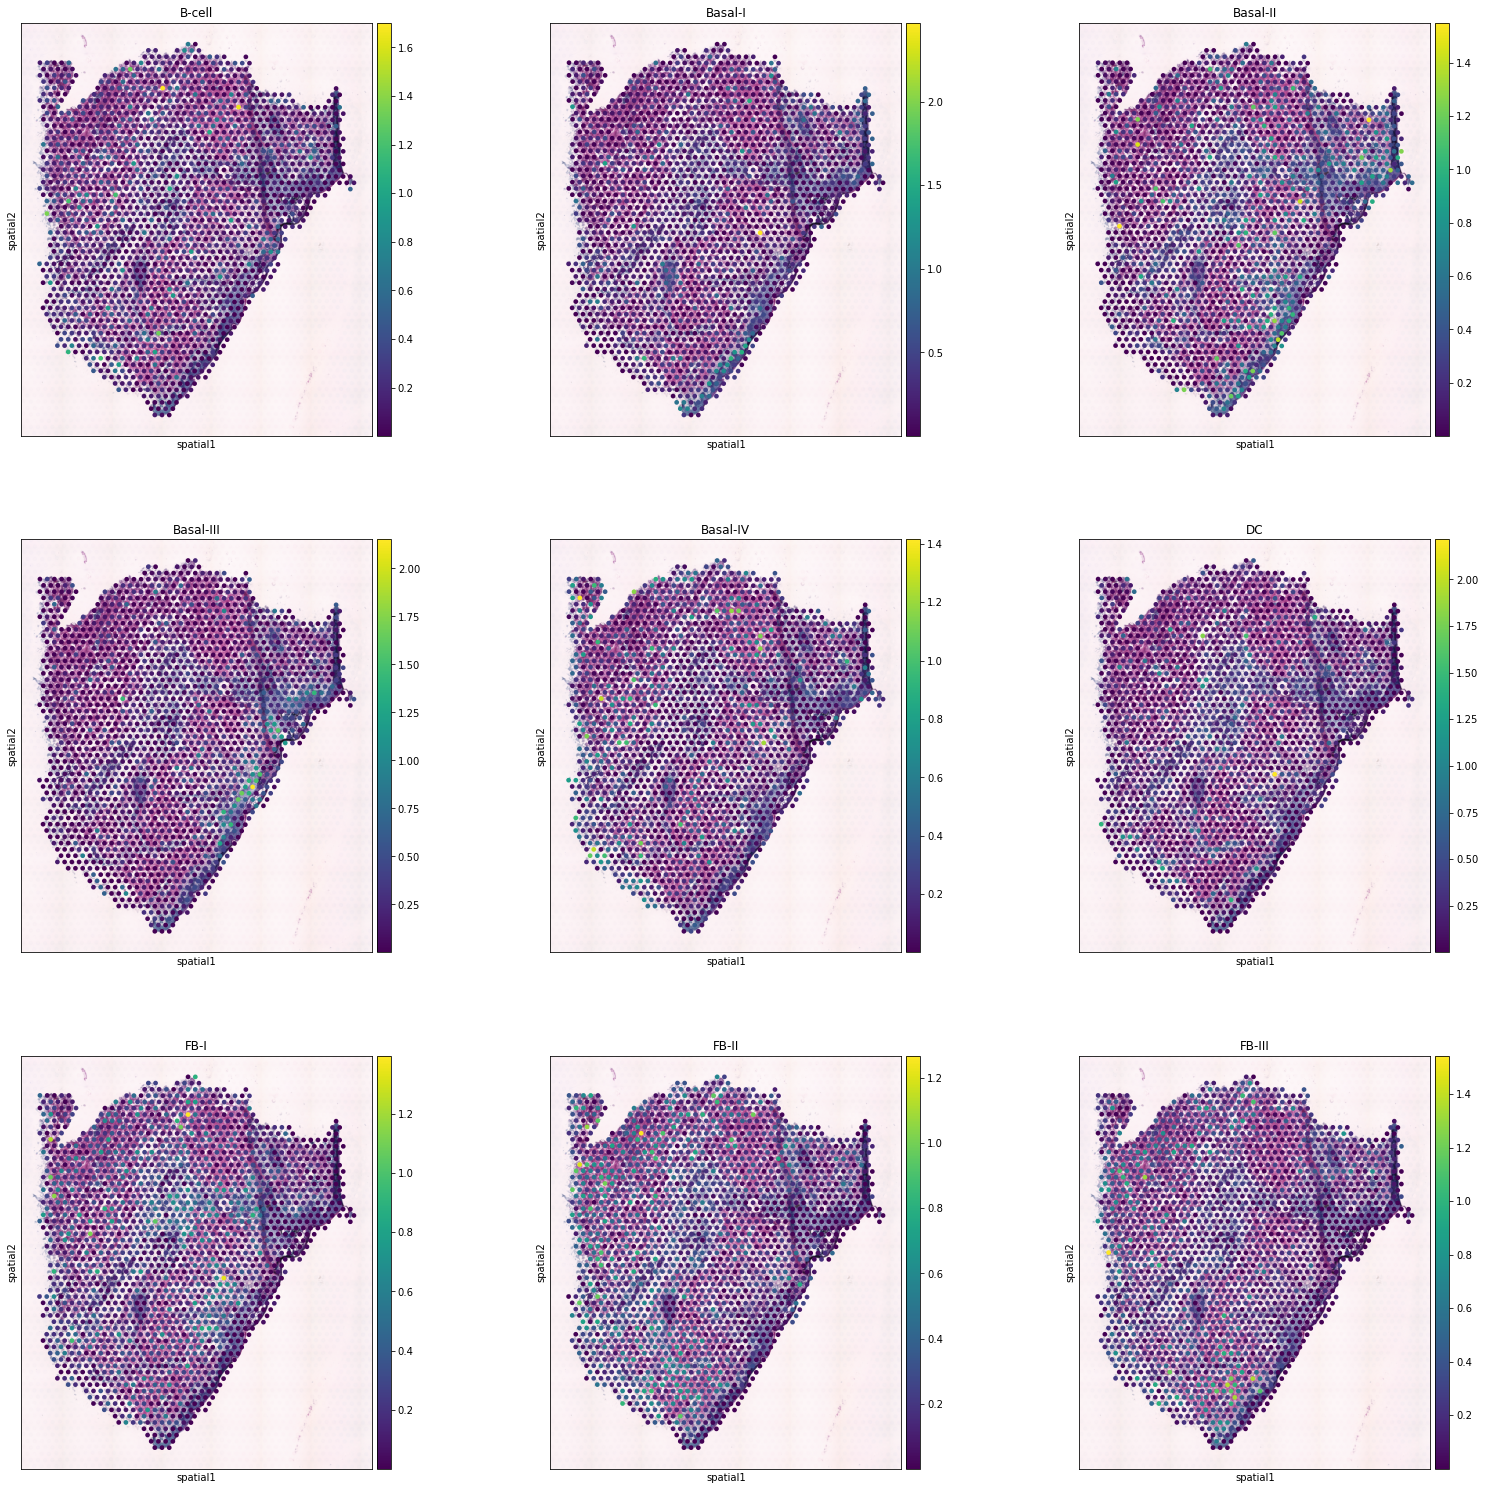

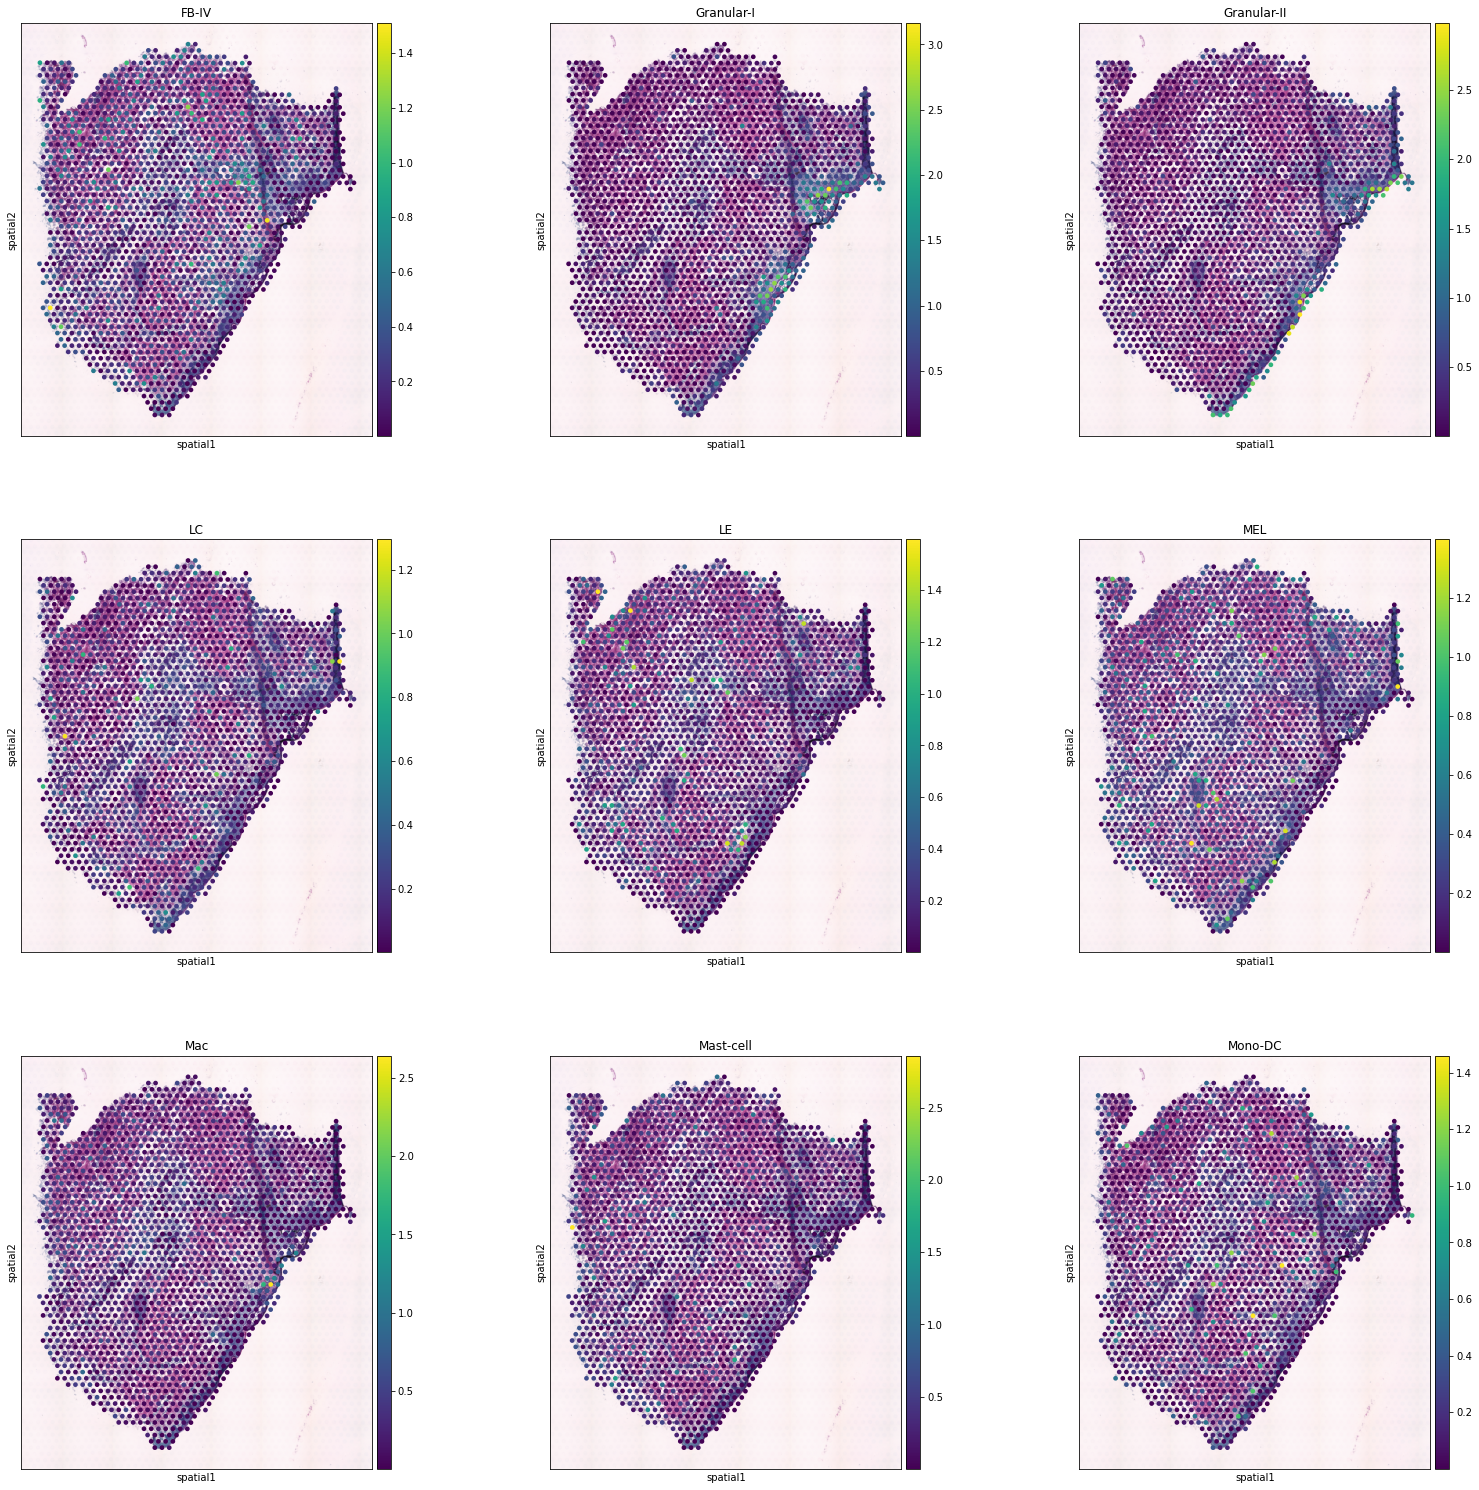

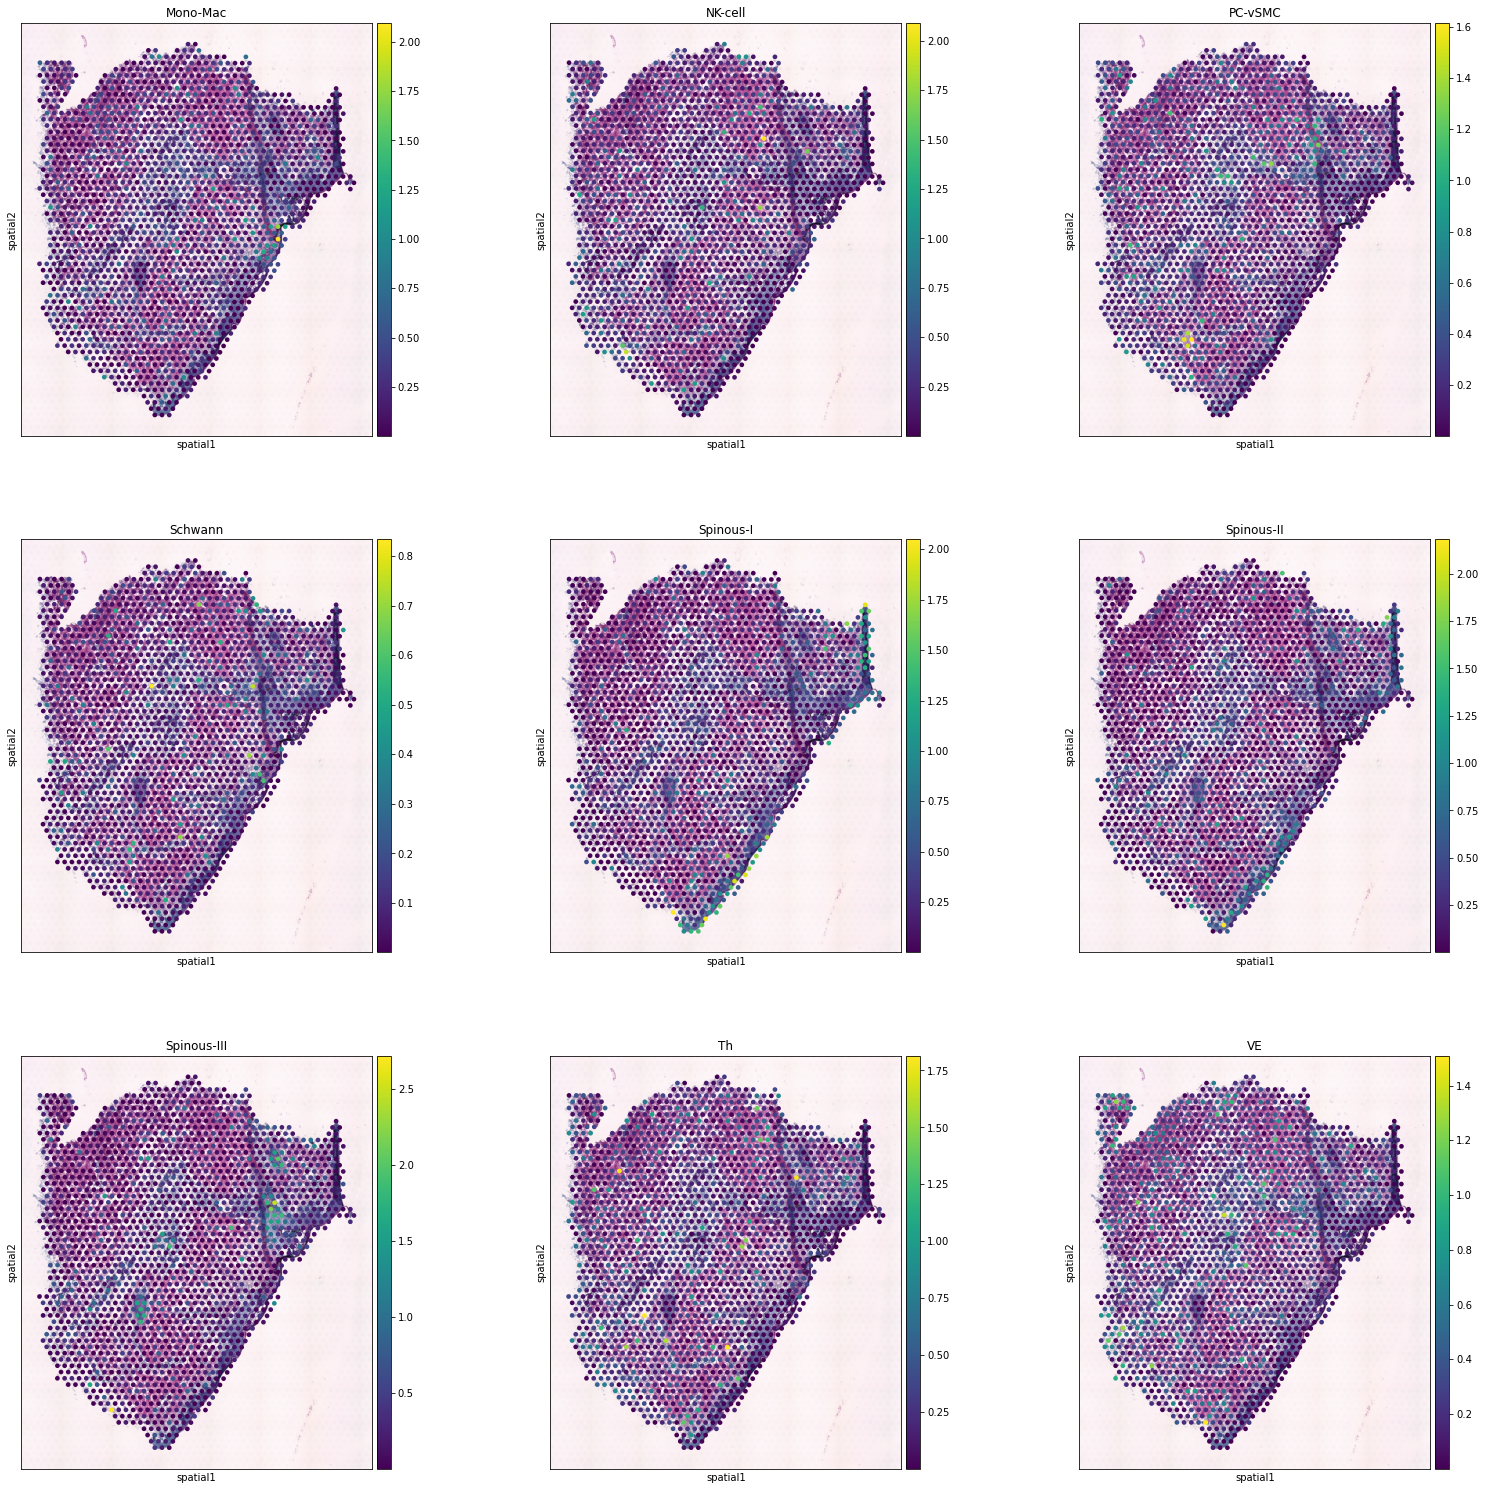

In [20]:
# plot 9 at a time (have 27 celltypes)
sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=celltypes[:9],
    ncols=3,
)
sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=celltypes[9:18],
    ncols=3,
)
sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=celltypes[18:27],
    ncols=3,
)

In [21]:
adata_st.obsm["tangram_ct_pred"]

Th   Basal-I        DC     FB-II        LE  \
AAACCGGGTAGGTACC-1  0.118297  0.121168  0.000144  0.899080  0.160199   
AAACCGTTCGTCCAGG-1  0.228139  0.061478  0.238398  0.307957  0.162057   
AAACCTCATGAAGTTG-1  0.648039  0.000114  0.000098  0.301508  0.208133   
AAACGAGACGGTTGAT-1  0.069638  0.216960  0.373708  0.056128  0.106864   
AAACGGTTGCGAACTG-1  0.205982  0.138979  0.273731  0.076123  0.000263   
...                      ...       ...       ...       ...       ...   
TTGTTCAGTGTGCTAC-1  0.189834  0.365677  0.000200  0.911222  0.257148   
TTGTTGTGTGTCAAGA-1  0.223231  0.344580  0.274986  0.250467  0.009871   
TTGTTTCACATCCAGG-1  0.135329  0.368297  0.113404  0.293400  0.085598   
TTGTTTCATTAGTCTA-1  0.354661  0.000220  0.947759  0.283293  0.169404   
TTGTTTCCATACAACT-1  0.000182  0.000475  0.391155  0.073299  0.054658   

                         MEL  Mast-cell       Mac  Granular-II    FB-III  ...  \
AAACCGGGTAGGTACC-1  0.146242   0.783276  0.198372     0.086577  0.486835  ...   
AAACCGTTCGTCCAGG-1  0.218504   0.113230  0.241671     0.032153  0.107300  ...   
AAACCTCATGAAGTTG-1  0.000152   0.471309  0.134737     0.000405  0.794806  ...   
AAACGAGACGGTTGAT-1  0.212545   0.190257  0.110475     0.000539  0.116502  ...   
AAACGGTTGCGAACTG-1  0.278179   0.000240  0.000294     0.000609  0.445031  ...   
...                      ...        ...       ...          ...       ...  ...   
TTGTTCAGTGTGCTAC-1  0.058352   0.190097  0.226215     0.187918  0.275392  ...   
TTGTTGTGTGTCAAGA-1  0.213634   0.033635  0.021610     0.139499  0.041472  ...   
TTGTTTCACATCCAGG-1  0.182142   0.193212  0.220778     0.000581  0.269226  ...   
TTGTTTCATTAGTCTA-1  0.050085   0.361980  0.016689     0.034069  0.349368  ...   
TTGTTTCCATACAACT-1  0.297104   0.382254  0.249834     0.066567  0.243559  ...   

                          LC  Spinous-I    B-cell  Basal-II        VE  \
AAACCGGGTAGGTACC-1  0.000147   0.000220  0.425178  0.000221  0.073647   
AAACCGTTCGTCCAGG-1  0.259798   0.170518  0.092015  0.206476  0.524145   
AAACCTCATGAAGTTG-1  0.214512   0.000118  0.333444  0.000351  0.000142   
AAACGAGACGGTTGAT-1  0.260646   0.132504  0.000832  0.361266  0.319661   
AAACGGTTGCGAACTG-1  0.279466   0.451987  0.099627  0.435266  0.126690   
...                      ...        ...       ...       ...       ...   
TTGTTCAGTGTGCTAC-1  0.028069   0.199935  0.021693  0.334084  0.154729   
TTGTTGTGTGTCAAGA-1  0.123722   0.188749  0.032863  0.213357  0.201727   
TTGTTTCACATCCAGG-1  0.087976   0.269272  0.211037  0.185141  0.156829   
TTGTTTCATTAGTCTA-1  0.000125   0.000159  0.138103  0.212417  0.297135   
TTGTTTCCATACAACT-1  0.073407   0.000293  0.367374  0.000311  0.121222   

                     NK-cell  Spinous-III  Basal-IV  Basal-III   Schwann  
AAACCGGGTAGGTACC-1  0.107062     0.073610  0.000280   0.057808  0.000176  
AAACCGTTCGTCCAGG-1  0.028447     0.269133  0.374702   0.268594  0.185188  
AAACCTCATGAAGTTG-1  0.226690     0.025105  0.108861   0.000096  0.108272  
AAACGAGACGGTTGAT-1  0.000414     0.268819  0.119923   0.100244  0.110906  
AAACGGTTGCGAACTG-1  0.169112     0.000721  0.096256   0.286709  0.022539  
...                      ...          ...       ...        ...       ...  
TTGTTCAGTGTGCTAC-1  0.000470     0.000367  0.334961   0.000269  0.116702  
TTGTTGTGTGTCAAGA-1  0.140471     0.041148  0.000600   0.237847  0.098800  
TTGTTTCACATCCAGG-1  0.331176     0.510821  0.042164   0.236005  0.193725  
TTGTTTCATTAGTCTA-1  0.263649     0.000163  0.499716   0.269943  0.073323  
TTGTTTCCATACAACT-1  0.041763     0.000258  0.774552   0.383021  0.065652  

[1725 rows x 27 columns]

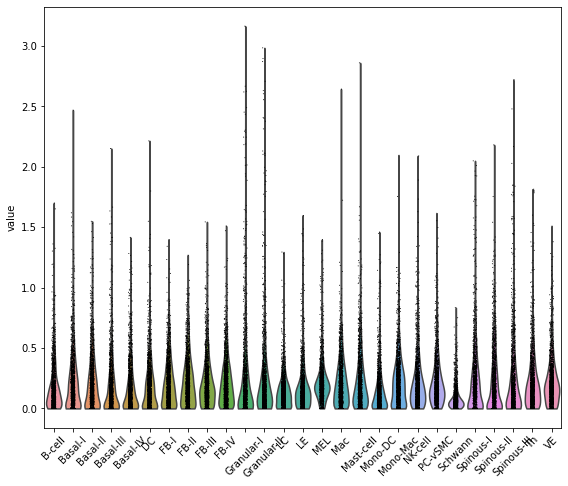

In [22]:
sc.pl.violin(adata_st, celltypes, rotation=45)



# Same but with lognorm

Run same analysis, but run lognorm of the data

In [23]:
sc.pp.log1p(adata_st)
sc.pp.log1p(adata_sc)

In [24]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:5114 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:21007 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [25]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="cells",
    scale=False,
    density_prior='rna_count_based',
    num_epochs=1000,
    device="cpu",
)


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5114 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.260, KL reg: 0.029
Score: 0.363, KL reg: 0.000
Score: 0.369, KL reg: 0.000
Score: 0.370, KL reg: 0.000
Score: 0.371, KL reg: 0.000
Score: 0.371, KL reg: 0.000
Score: 0.371, KL reg: 0.000
Score: 0.372, KL reg: 0.000
Score: 0.372, KL reg: 0.000
Score: 0.372, KL reg: 0.000


INFO:root:Saving results..


In [26]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cl.annot")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [31]:
adata_st.obsm["tangram_ct_pred"].to_csv(os.path.join(outdir,"tangram_fc0.5_pval0.01_lognorm.csv"))

In [33]:
# add another colame
adata_st.obsm["tangram_ct_pred"].columns += "_ln"
celltypes2 = list(adata_st.obsm["tangram_ct_pred"].columns)

adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)


In [29]:
#sel = adata_st.obs.columns[:41]
#adata_st.obs = adata_st.obs[sel]
#adata_st.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'n_counts', 'uniform_density', 'rna_count_based_density', 'Th',
       'Basal-I', 'DC', 'FB-II', 'LE', 'MEL', 'Mast-cell', 'Mac',
       'Granular-II', 'FB-III', 'Mono-Mac', 'Spinous-II', 'Mono-DC',
       'Granular-I', 'PC-vSMC', 'FB-IV', 'FB-I', 'LC', 'Spinous-I', 'B-cell',
       'Basal-II', 'VE', 'NK-cell', 'Spinous-III', 'Basal-IV', 'Basal-III',
       'Schwann'],
      dtype='object')

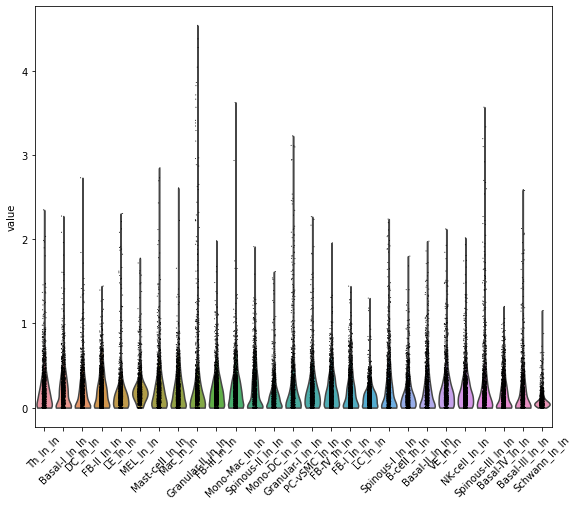

In [35]:
sc.pl.violin(adata_st, celltypes2, rotation=45)

Even more uniform with lognorm

Comments from
https://github.com/broadinstitute/Tangram/issues/3

Applying log-transform
Although applying log(1+x) is critical in computing marker genes, we do not find it essential for mapping. We may, or may not, apply log(1+x). If so, we make sure to apply to both spatial data and scRNAseq data. It is important that both datasets are processed in the same way. 


In tutorial: https://github.com/broadinstitute/Tangram/blob/master/tutorial_sq_tangram.ipynb

They have lognormed data and still use `density_prior='rna_count_based'`

Comments from
https://github.com/broadinstitute/Tangram/issues/3

Mapping on Visium data
If you do not have good prior knowledge of the number of cells in each voxel, then deconvolution using Tangram can be challenging. This is what we usually do:

Rather than inputting a uniform density, we set $\lamba_d = 0$, in order to turn off the density term (the KL divergence term). If we are using the Mapping object, we may or may not turn off the entropy regularizer (usually I see how the entropy looks like w/o regularization). If we are using the MappingConstrained object, we also turn off the count term (which sets a soft constraint for the "total" number of cells), and the filter regularizer.
After mapping, we look at probability maps of cell types and prediction of gene expression of test genes not included in training. If they look OK, we call it a good mapping and start looking at cool things (programs distributed in space, reconstruction of low-quality genes etc). You don't need to deconvolve for achieving this.
If you really want to deconvolve your data, but you do not know about cell number within voxels, you can use MappingConstrained with settings above and manually inspect the learn filters. That would give you a prediction for the "learned" number of cells. We have not documented this case though in the manuscript, and we are unsure about how well it works.

In [36]:
help(tg.map_cells_to_space)

Help on function map_cells_to_space in module tangram.mapping_utils:

map_cells_to_space(adata_sc, adata_sp, cv_train_genes=None, cluster_label=None, mode='cells', device='cpu', learning_rate=0.1, num_epochs=1000, scale=True, lambda_d=0, lambda_g1=1, lambda_g2=0, lambda_r=0, lambda_count=1, lambda_f_reg=1, target_count=None, random_state=None, verbose=True, density_prior='rna_count_based')
    Map single cell data (`adata_sc`) on spatial data (`adata_sp`).
    
    Args:
        adata_sc (AnnData): single cell data
        adata_sp (AnnData): gene spatial data
        cv_train_genes (list): Optional. Training gene list. Default is None.
        cluster_label (str): Optional. Field in `adata_sc.obs` used for aggregating single cell data. Only valid for `mode=clusters`.
        mode (str): Optional. Tangram mapping mode. Currently supported: 'cell', 'clusters', 'constrained'. Default is 'cell'.
        device (string or torch.device): Optional. Default is 'cpu'.
        learning_rate (fl